In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm
from PIL import ImageFilter


In [52]:
class ImageBoundingBoxDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_transform=None, label_transform=None):
        """
        Args:
            image_dir: Path to the directory containing images.
            label_dir: Path to the directory containing density maps/labels.
            image_transform: Transformations for input images.
            label_transform: Transformations for target labels (density maps).
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_transform = image_transform
        self.label_transform = label_transform

        # List of image and label files
        self.image_files = sorted(os.listdir(image_dir))
        self.label_files = sorted(os.listdir(label_dir))

        # Ensure images and labels match
        assert len(self.image_files) == len(self.label_files), \
            "Mismatch between number of images and labels."

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert("RGB")  # Convert to grayscale

        # Load label (density map)
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        label = Image.open(label_path).convert("L")  # Convert to grayscale

        # Apply separate transformations
        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            label = self.label_transform(label)

        return image, label


In [53]:
import torch
import torch.nn as nn
import torch.nn.init as init

class FullyConvolutionalRegressionNetwork_A(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        """
        Args:
            input_channels: Number of input channels.
            output_channels: Number of output channels (e.g., 1 for depth maps).
        """
        super(FullyConvolutionalRegressionNetwork_A, self).__init__()

        # Encoder (feature extraction)
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
           
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1)  # Final convolution
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1),  # Learnable upsampling
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, output_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        """Forward pass of the network.

        Args:
            x: Input tensor of shape (batch_size, input_channels, height, width)

        Returns:
            Output tensor of shape (batch_size, output_channels, height, width)
        """
        x = self.encoder(x)
        x = self.decoder(x)
        
        #x = F.interpolate(x, size=(100, 100), mode='bilinear', align_corners=True)

        return x


In [54]:
import torch
import torch.nn as nn
import torch.nn.init as init

class FullyConvolutionalRegressionNetwork_B(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        """
        Args:
            input_channels: Number of input channels.
            output_channels: Number of output channels (e.g., 1 for depth maps).
        """
        super(FullyConvolutionalRegressionNetwork_B, self).__init__()

        # Encoder (feature extraction)
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
           
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Final convolution
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Learnable upsampling
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, output_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        """Forward pass of the network.

        Args:
            x: Input tensor of shape (batch_size, input_channels, height, width)

        Returns:
            Output tensor of shape (batch_size, output_channels, height, width)
        """
        x = self.encoder(x)
        x = self.decoder(x)
        
        x = F.interpolate(x, size=(100, 100), mode='bilinear', align_corners=True)

        return x


In [55]:
# Create the model
#model = FullyConvolutionalRegressionNetwork_A(input_channels=3, output_channels=1)
#dummy_input = torch.randn(2, 3, 512, 512)
model = FullyConvolutionalRegressionNetwork_B(input_channels=3, output_channels=1)
dummy_input = torch.randn(2, 3, 100, 100)

# Forward pass
output = model(dummy_input)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([2, 3, 100, 100])
Output shape: torch.Size([2, 1, 100, 100])


In [56]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
image_transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for RGB images
])

label_transform = transforms.Compose([
    transforms.ToTensor(),
      
])

# Dataset paths
#image_dir = "custom/images/train"
#label_dir = "output/heatmaps"

image_dir = "augmented/images"
label_dir = "augmented/labels"

# Instantiate dataset with distinct transformations
dataset = ImageBoundingBoxDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    image_transform=image_transform,
    label_transform=label_transform
)

# Split dataset into train, validation, and test
total_size = len(dataset)
train_size = int(0.7 * total_size)  # 70% for training
val_size = int(0.15 * total_size)   # 15% for validation
test_size = total_size - train_size - val_size  # Remaining 15% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Training size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)


Training size: 1732, Validation size: 371, Test size: 372


In [57]:
# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Select device (MPS or CPU)
print(torch.backends.mps.is_available())

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print('Using device:', device)  


True
Using device: mps


Starting epoch number 1


Epoch 1 - Training: 100%|██████████| 217/217 [00:05<00:00, 39.89batch/s]


Epoch 1 - Training Loss: 0.0131


Epoch 1 - Validation: 100%|██████████| 47/47 [00:00<00:00, 48.52batch/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].


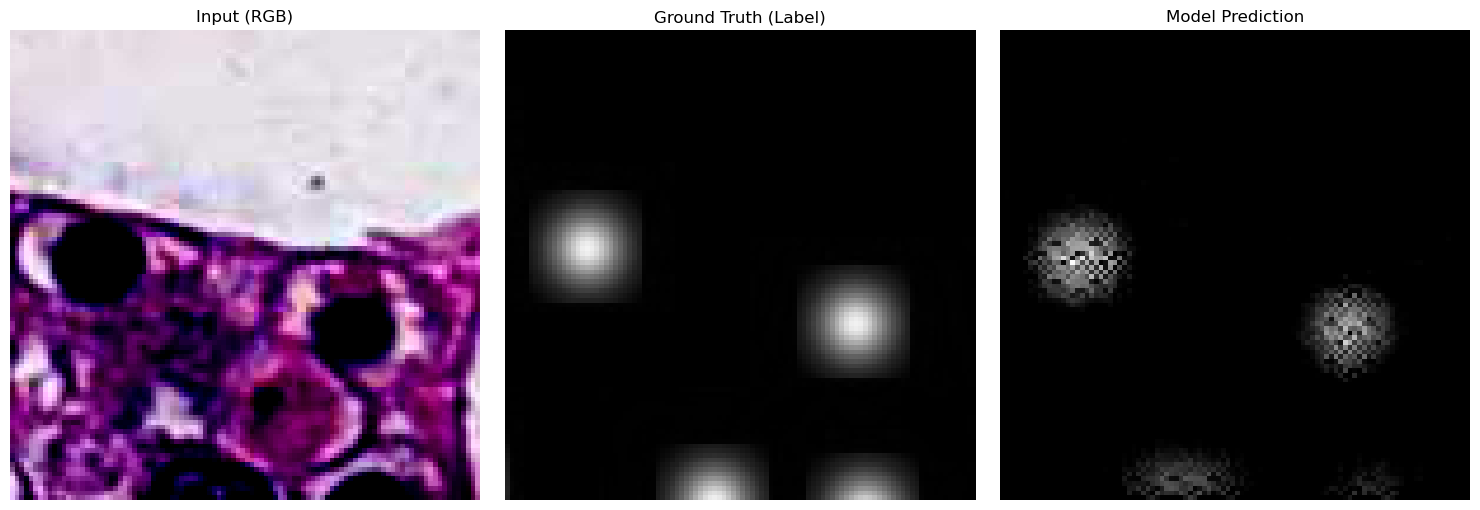

Epoch 1 - Validation Loss: 0.0105
Starting epoch number 2


Epoch 2 - Training: 100%|██████████| 217/217 [00:05<00:00, 40.79batch/s]


Epoch 2 - Training Loss: 0.0089


Epoch 2 - Validation: 100%|██████████| 47/47 [00:00<00:00, 49.55batch/s]


Epoch 2 - Validation Loss: 0.0077
Starting epoch number 3


Epoch 3 - Training: 100%|██████████| 217/217 [00:05<00:00, 39.39batch/s]


Epoch 3 - Training Loss: 0.0081


Epoch 3 - Validation: 100%|██████████| 47/47 [00:00<00:00, 52.01batch/s]


Epoch 3 - Validation Loss: 0.0072
Starting epoch number 4


Epoch 4 - Training: 100%|██████████| 217/217 [00:05<00:00, 38.82batch/s]


Epoch 4 - Training Loss: 0.0075


Epoch 4 - Validation: 100%|██████████| 47/47 [00:00<00:00, 52.68batch/s]


Epoch 4 - Validation Loss: 0.0071
Starting epoch number 5


Epoch 5 - Training: 100%|██████████| 217/217 [00:05<00:00, 40.06batch/s]


Epoch 5 - Training Loss: 0.0071


Epoch 5 - Validation: 100%|██████████| 47/47 [00:00<00:00, 50.99batch/s]


Epoch 5 - Validation Loss: 0.0067
Starting epoch number 6


Epoch 6 - Training: 100%|██████████| 217/217 [00:05<00:00, 39.55batch/s]


Epoch 6 - Training Loss: 0.0070


Epoch 6 - Validation: 100%|██████████| 47/47 [00:00<00:00, 51.81batch/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].


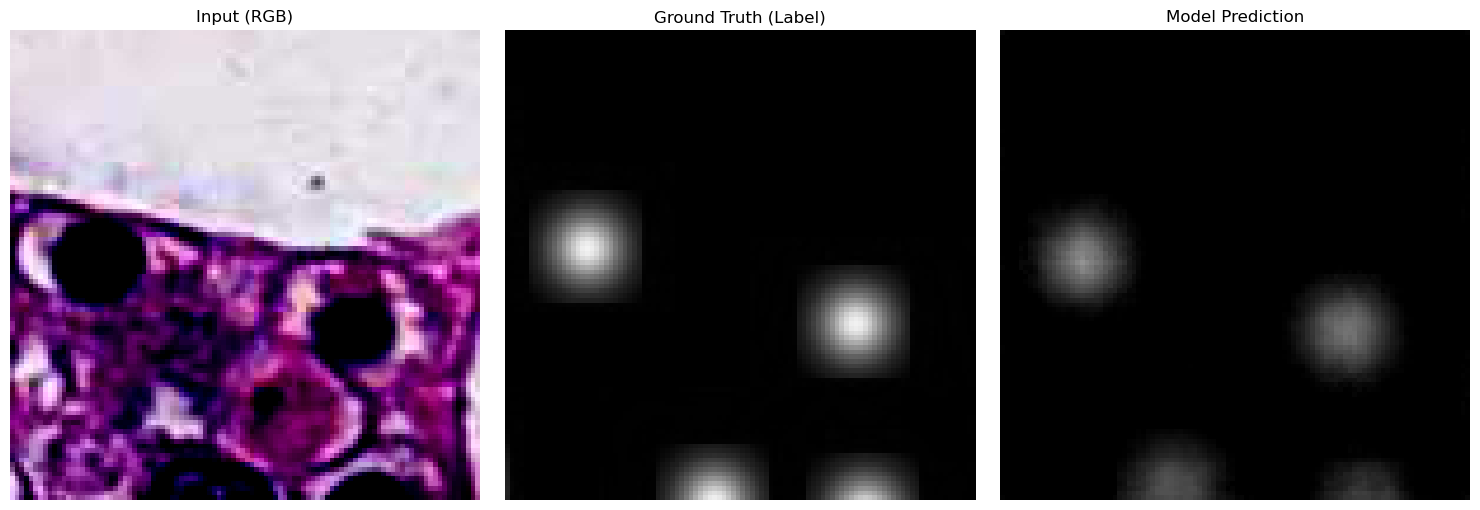

Epoch 6 - Validation Loss: 0.0074
Starting epoch number 7


Epoch 7 - Training: 100%|██████████| 217/217 [00:05<00:00, 38.89batch/s]


Epoch 7 - Training Loss: 0.0068


Epoch 7 - Validation: 100%|██████████| 47/47 [00:00<00:00, 52.20batch/s]


Epoch 7 - Validation Loss: 0.0076
Starting epoch number 8


Epoch 8 - Training: 100%|██████████| 217/217 [00:05<00:00, 38.29batch/s]


Epoch 8 - Training Loss: 0.0067


Epoch 8 - Validation: 100%|██████████| 47/47 [00:00<00:00, 48.25batch/s]


Epoch 8 - Validation Loss: 0.0066
Starting epoch number 9


Epoch 9 - Training: 100%|██████████| 217/217 [00:05<00:00, 38.60batch/s]


Epoch 9 - Training Loss: 0.0066


Epoch 9 - Validation: 100%|██████████| 47/47 [00:00<00:00, 51.56batch/s]


Epoch 9 - Validation Loss: 0.0071
Starting epoch number 10


Epoch 10 - Training: 100%|██████████| 217/217 [00:05<00:00, 38.50batch/s]


Epoch 10 - Training Loss: 0.0066


Epoch 10 - Validation: 100%|██████████| 47/47 [00:00<00:00, 50.17batch/s]


Epoch 10 - Validation Loss: 0.0063
Starting epoch number 11


Epoch 11 - Training: 100%|██████████| 217/217 [00:05<00:00, 39.24batch/s]


Epoch 11 - Training Loss: 0.0065


Epoch 11 - Validation: 100%|██████████| 47/47 [00:00<00:00, 51.15batch/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].


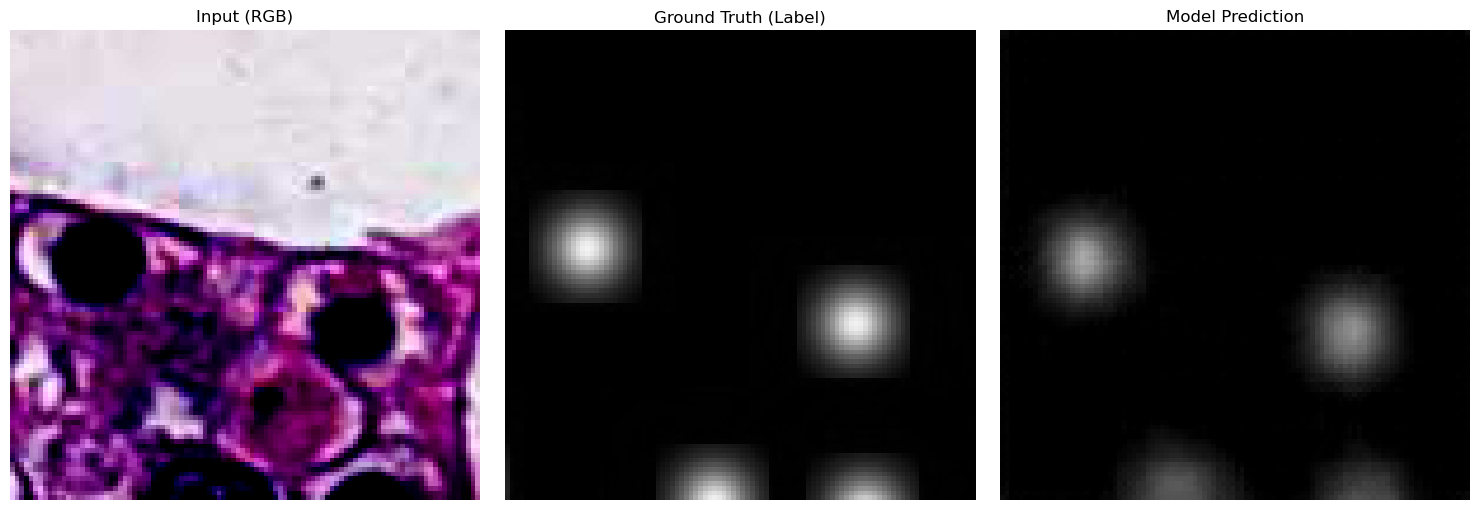

Epoch 11 - Validation Loss: 0.0063
Starting epoch number 12


Epoch 12 - Training: 100%|██████████| 217/217 [00:05<00:00, 39.10batch/s]


Epoch 12 - Training Loss: 0.0063


Epoch 12 - Validation: 100%|██████████| 47/47 [00:00<00:00, 52.72batch/s]


Epoch 12 - Validation Loss: 0.0064
Starting epoch number 13


Epoch 13 - Training: 100%|██████████| 217/217 [00:05<00:00, 39.01batch/s]


Epoch 13 - Training Loss: 0.0063


Epoch 13 - Validation: 100%|██████████| 47/47 [00:00<00:00, 52.15batch/s]


Epoch 13 - Validation Loss: 0.0062
Starting epoch number 14


Epoch 14 - Training: 100%|██████████| 217/217 [00:05<00:00, 39.35batch/s]


Epoch 14 - Training Loss: 0.0061


Epoch 14 - Validation: 100%|██████████| 47/47 [00:00<00:00, 52.24batch/s]


Epoch 14 - Validation Loss: 0.0060
Starting epoch number 15


Epoch 15 - Training: 100%|██████████| 217/217 [00:05<00:00, 38.56batch/s]


Epoch 15 - Training Loss: 0.0062


Epoch 15 - Validation: 100%|██████████| 47/47 [00:00<00:00, 48.82batch/s]


Epoch 15 - Validation Loss: 0.0061
Starting epoch number 16


Epoch 16 - Training: 100%|██████████| 217/217 [00:05<00:00, 37.72batch/s]


Epoch 16 - Training Loss: 0.0059


Epoch 16 - Validation: 100%|██████████| 47/47 [00:00<00:00, 51.89batch/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].


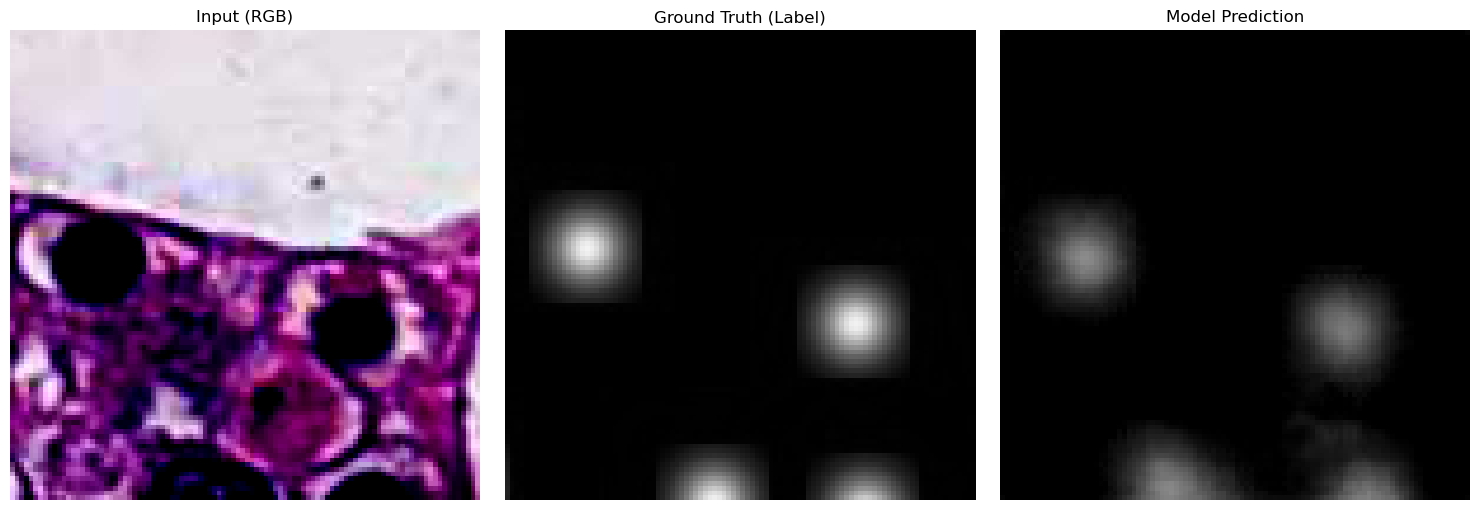

Epoch 16 - Validation Loss: 0.0061
Starting epoch number 17


Epoch 17 - Training: 100%|██████████| 217/217 [00:05<00:00, 37.35batch/s]


Epoch 17 - Training Loss: 0.0058


Epoch 17 - Validation: 100%|██████████| 47/47 [00:00<00:00, 49.89batch/s]


Epoch 17 - Validation Loss: 0.0068
Starting epoch number 18


Epoch 18 - Training: 100%|██████████| 217/217 [00:05<00:00, 40.52batch/s]


Epoch 18 - Training Loss: 0.0059


Epoch 18 - Validation: 100%|██████████| 47/47 [00:00<00:00, 49.83batch/s]


Epoch 18 - Validation Loss: 0.0075
Starting epoch number 19


Epoch 19 - Training: 100%|██████████| 217/217 [00:05<00:00, 38.42batch/s]


Epoch 19 - Training Loss: 0.0057


Epoch 19 - Validation: 100%|██████████| 47/47 [00:00<00:00, 52.28batch/s]


Epoch 19 - Validation Loss: 0.0060
Starting epoch number 20


Epoch 20 - Training: 100%|██████████| 217/217 [00:05<00:00, 39.92batch/s]


Epoch 20 - Training Loss: 0.0055


Epoch 20 - Validation: 100%|██████████| 47/47 [00:00<00:00, 50.93batch/s]

Epoch 20 - Validation Loss: 0.0068
Training complete.


In [58]:
import matplotlib.pyplot as plt

model.to(device)

num_epochs = 20
training_losses = []
validation_losses = []

# Training Loop with tqdm
for epoch in range(num_epochs):
    print(f"Starting epoch number {epoch + 1}")

    model.train()
    running_train_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training", unit="batch"):
        inputs, labels = batch  # inputs: image, labels: heatmap

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = loss_fn(outputs, labels)
        running_train_loss += loss.item()

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    avg_train_loss = running_train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")

    # Validation Loop
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1} - Validation", unit="batch"):
            inputs, labels = batch

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_fn(outputs, labels)
            running_val_loss += loss.item()

        # Visualization
        if epoch % 5 == 0:  # Visualize only every 5th epoch
            plt.figure(figsize=(15, 5))

            # Plot input image (grayscale)
            img = inputs[0].cpu().permute(1, 2, 0).numpy()  # Convert to HxWxC format for RGB
            img = np.clip(img, 0, 1)  # Clip values to the range [0, 1]
            plt.subplot(1, 3, 1)
            plt.imshow(img)  # Display as RGB
            plt.title("Input (RGB)")
            plt.axis('off')

            # Plot ground truth (grayscale)
            ground_truth = labels[0].cpu().numpy().squeeze()  # Get the first ground truth heatmap
            plt.subplot(1, 3, 2)
            plt.imshow(ground_truth, cmap='gray', vmin=0, vmax=1)  # Adjust as needed
            plt.title("Ground Truth (Label)")
            plt.axis('off')

            # Plot model prediction (grayscale)
            prediction = outputs[0].cpu().detach().numpy().squeeze()  # Get the first prediction
            plt.subplot(1, 3, 3)
            plt.imshow(prediction, cmap='gray', vmin=0, vmax=1)  # Adjust as needed
            plt.title("Model Prediction")
            plt.axis('off')

            # Show the plots
            plt.tight_layout()
            plt.show()


    avg_val_loss = running_val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

print("Training complete.")


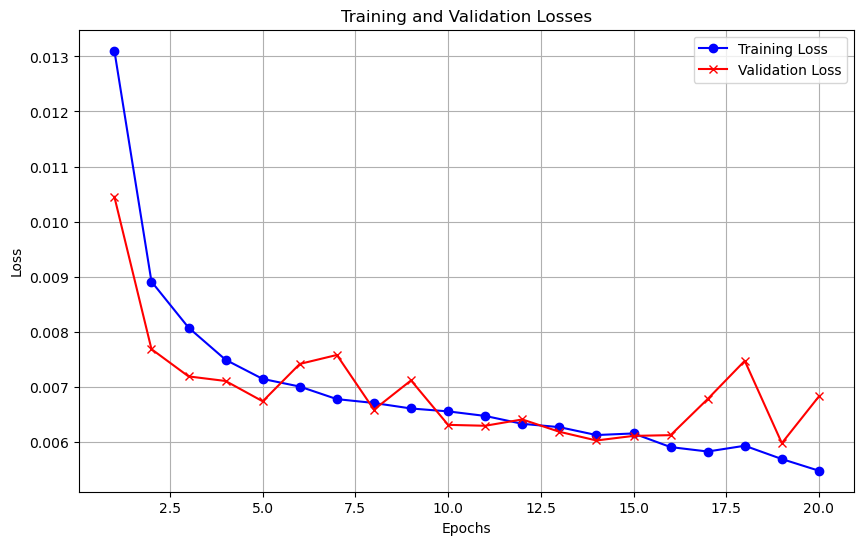

In [60]:
import matplotlib.pyplot as plt

# Plotting training and validation losses
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss', color='blue', marker='o')

# Plot validation loss
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', color='red', marker='x')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Show plot
plt.grid(True)
plt.show()
